In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_absolute_error
from sklearn.feature_selection import mutual_info_regression

from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

def make_mi_scores(X, y):
    X = X.copy()
    X = X.fillna(0)
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [7]:
data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')

y = data_train.Transported

data_train.select_dtypes(['object']).nunique().sort_values(ascending=False)

PassengerId    8693
Name           8473
Cabin          6560
HomePlanet        3
Destination       3
CryoSleep         2
VIP               2
dtype: int64

In [21]:
features = ['HomePlanet','CryoSleep', 'Age', 'RoomService', 'VRDeck']
planets = {'Europa': 1, 'Earth': 2, 'Mars': 3}

X = data_train[features]
X['CryoSleep'] = X['CryoSleep'].astype(bool).astype(int)
X['HomePlanet'] = X['HomePlanet'].replace(planets)

mi_scores = make_mi_scores(X, y)

data_test_pr = data_test[features]
data_test_pr['CryoSleep'] = data_test_pr['CryoSleep'].astype(bool).astype(int)
data_test_pr['HomePlanet'] = data_test_pr['HomePlanet'].replace(planets)

X_train, X_valid, y_train, y_valid = train_test_split(X, y)

CryoSleep      0.104694
RoomService    0.070254
VRDeck         0.045581
HomePlanet     0.020373
Age            0.019773
Cabin          0.000000
Name: MI Scores, dtype: float64


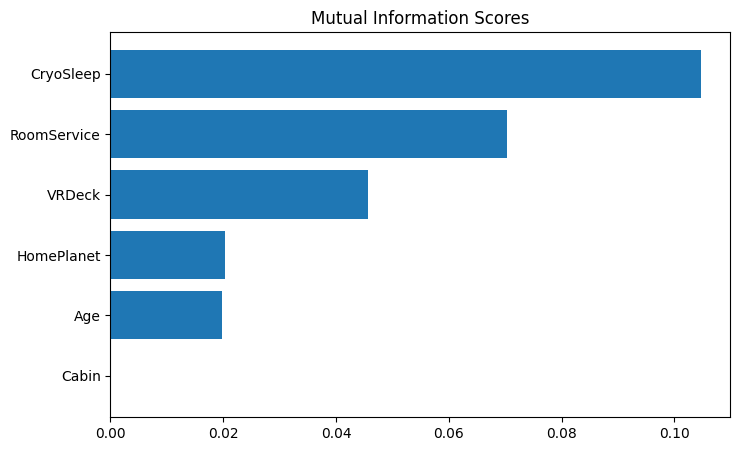

In [22]:
print(mi_scores)
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [23]:
my_model = XGBRegressor(n_estimators = 100, learning_rate=0.01, n_jobs = 4)
my_model.fit(X_train, y_train,
             early_stopping_rounds = 5,
             eval_set=[(X_valid, y_valid)],
             verbose = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=4,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
predictions = my_model.predict(X_valid)
print("Mean Absolute Error: " + str(mean_absolute_error(predictions, y_valid)))

Mean Absolute Error: 0.39326286


In [25]:
predict_test = my_model.predict(data_test_pr)
output = pd.DataFrame({'PassengerId': data_test.PassengerId,
                       'Transported': np.round(predict_test).astype(bool)})
output.to_csv('submission.csv', index=False)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:Cabin: object